In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

## What is estimate breadth?

$\textrm{estimate breadth} = \frac{\textrm{estimate upgrades - estimate downgrades}}{\textrm{total number of estimates}}$

## Why is it not sufficient on its own?

Consider the case of the following 3 Amazon review histories for three sellers:
    * 2/2 positive reviews. 100 % positive
    * 9/10 positive reviews. 90 % positive 
    * 88/100 postiive reviews. 88% positive

Clearly not all of the review histories are equal, and you would probably feel that seller number 3 is going to give you the best experience. But how do we incorporate this in mathematically?

With a Bayesian prior obviously... With a uniform prior (i.e. one additional negative and positive review), we can retrieve a postierior that is closer to our real beliefs. Taking the first seller as an example:

$$\textrm{(Prior 1)     Bin} \sim (\hat{p} = \frac{1}{2}, n = 2)$$
$$\textrm{(Prior 2)      Bin} \sim (\hat{p} = \frac{2}{2}, n = 2)$$

$$\textrm{(Posterior)      Beta} \sim (\hat{\alpha} = \frac{3}{4}, \hat{\beta} = \frac{1}{4})$$

$$\hat{\mathbb{E}}[\textrm{Success}_{\textrm{post}}] = \frac{\frac{3}{4} + \frac{1}{4}}{\frac{3}{4}} = 75\%$$

Whereas it is $87.2\%$ for seller 3.

Thats pretty neat. The true optimal solution is actually the center of mass for the beta PDF... but we do not want to do any hectic maths in the calculation, so this quick and dirty alternative will work great for us.

## Laplace breadth

I propose we call it Laplace breadth because although pastor Bayes discovered the formula, he was a layman, and his work gained no notice until Laplace dragged it kicking and screaming into 20th century maths along with the rest of probability theory. And Laplace even proposed a similar thought experiment in his own writings.

The revised estimate breadth formula is:

$$\textrm{laplace breadth} = \frac{(\textrm{estimate upgrades} + 1) - (\textrm{estimate downgrades} + 1)}{\textrm{total estimates} + 2}$$

$$\textrm{laplace breadth} = \frac{(\textrm{estimate upgrades}) - (\textrm{estimate downgrades})}{\textrm{total estimates} + 2}$$

In [2]:
est_data = pd.read_csv("C:/model_data/estimate_raw.csv")

In [3]:
type(est_data)

pandas.core.frame.DataFrame

In [4]:
est_data.head()

,Unnamed: 0,security_id,broker_id,period_date,estimate_date,value,currency,source_id
0,0,30064875557,-1676276586,2018-12-31,2019-03-21,0.49000,CNY,ibes
1,1,30064875557,-1676276586,2019-12-31,2019-03-21,0.62000,CNY,ibes
2,2,30064875557,-1676276586,2020-12-31,2019-03-21,0.79000,CNY,ibes
3,3,30064799557,-705587338,2019-12-31,2019-03-21,0.52727,HKD,ibes
4,4,30064799557,-705587338,2020-12-31,2019-03-21,0.57273,HKD,ibes


In [5]:
est_data.dtypes

Unnamed: 0         int64
security_id        int64
broker_id          int64
period_date       object
estimate_date     object
value            float64
currency          object
source_id         object
dtype: object

We need to change data columns to date types

In [6]:
# would like to change the source_id column to a category to save memory
est_data['source_id'] = est_data['source_id'].astype('category')

In [7]:
est_data['period_date'] = pd.to_datetime(est_data['period_date'])
est_data['estimate_date'] = pd.to_datetime(est_data['estimate_date'])

In [8]:
est_data.dtypes

Unnamed: 0                int64
security_id               int64
broker_id                 int64
period_date      datetime64[ns]
estimate_date    datetime64[ns]
value                   float64
currency                 object
source_id              category
dtype: object

Now we need to check the date range... The estimate date refers to the date when the estimate was made and not the forward earnings date that is is applied to (Which is the period date)

In [9]:
max(est_data['estimate_date'])

Timestamp('2020-03-20 00:00:00')

In [10]:
min(est_data['estimate_date'])

Timestamp('2019-03-21 00:00:00')

So for this working example we have a years worth of data...

Now we can set the key to the four columns that together uniquely identify a row

Now we need a change in estimates, so we need a before date, and a after date.

Additionally we need a lag period - the minimum amount of time we are willing to tolerate between the start and the end of the revision. 

Where there are no before and after dates for the estimates subject to the lag period then those data points need to be discarded

In [1]:
# might be a potential boon to performance to sort then run these methods...

lag_tol = 90

max_date = (est_data.groupby(['security_id', 'broker_id', 'period_date'])
     ['estimate_date']
     .max()
)
min_date = (est_data.groupby(['security_id', 'broker_id', 'period_date'])
     ['estimate_date']
     .min()
)
lag_in = (max_date - min_date).dt.days > lag_tol
lag_in

NameError: name 'est_data' is not defined

In [12]:
est_data = (est_data
               .join(
                    lag_in, 
                    on = ['security_id', 'broker_id', 'period_date'],
                    rsuffix = '_diff'
               )
           )

In [13]:
est_data_revised = est_data[est_data.estimate_date_diff == True]

Now we need to change the estimate date column to a daily index that we can swim through to record the number of upward and downward revisions...

Be careful of memory issues when you do this...

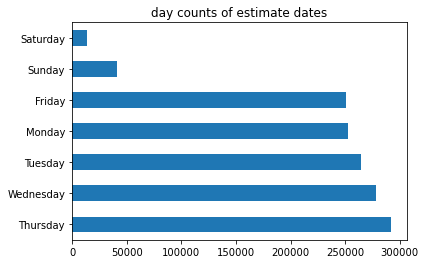

In [14]:
fig, ax = plt.subplots(figsize = (6,4))

(est_data_revised
     ['estimate_date']
     .dt.day_name()
     .value_counts()
     .plot.barh(title = 'day counts of estimate dates', ax  = ax)
)
# why are there Saturdays and Sundays in this thing? curious... Earnings season?
# also, why are analysts so lazy on Fridays and Mondays?

In [15]:
(est_data_revised
    .groupby([est_data_revised['estimate_date'].dt.month_name()
             , est_data_revised['estimate_date'].dt.day_name().rename('day')])
    .size()
    .unstack('day')
)
# so it does look like an earnings season thing...
# but also - how cool is this functionality :) would do a heatmap if I wasn't working

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
estimate_date,,,,,,,
April,18542,28045,896,2829,24589,30593,24002
August,35409,21617,1894,2960,39298,24506,26739
December,7842,13537,429,3507,10537,11569,11159
February,22618,20611,2617,4382,26684,22402,24392
January,21344,21634,868,3491,23681,22147,22409
July,21678,28342,1092,2768,24641,29450,33049
June,10022,13348,559,2370,11910,12581,12832
March,18557,19553,852,4155,18389,18451,18735
May,27269,19788,1741,2683,34012,23665,31924


Upsampling could lead to some serious memory issues... Not sure how to combat this?

Perhaps try reduce the memory of the data frame first so that all non essentials
such as the final three columns can be dealt with...

The above code just makes a resampler object that is intended for calculation, thts wh I propose 

In [16]:
est_data_revised.drop(['currency', 'Unnamed: 0', 'source_id', 'estimate_date_diff'], axis = 1, inplace = True)

C:\Apps\Python\Python37\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
est_data_revised.sort_values(['security_id', 'broker_id', 'period_date'], inplace = True)

C:\Apps\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
est_data_revised.shape

(1392934, 5)

The below takes about 26  minutes to run... but I don't care... for now :)

In [43]:
est_2 = (
    est_data_revised.head(100)
    .set_index(['security_id', 'broker_id', 'period_date'])
    .groupby(['security_id', 'broker_id', 'period_date'])
    .apply(
        lambda df: df.drop_duplicates('estimate_date')
                     .set_index('estimate_date')
                     .resample('D')
                     .ffill()
    )
)

In [44]:
est_gp = (est_2
          .reset_index('estimate_date')
          .groupby(['security_id', 
                    'broker_id', 
                    'period_date'])
         )

In [2]:
for gp_name, gp_df in est_2.groupby(['security_id', 'broker_id', 'period_date']):
    changes = (gp_df.value[lag_tol:]
               .subtract(gp_df.value[:(-lag_tol)])
               .fillna(0)
              )
    gp_df.assign()

NameError: name 'est_2' is not defined

In [38]:
change_df

estimate_date value
security_id broker_id   period_date                    
30064771087 -2084193872 2020-08-31            NaN   NaN
                        2020-08-31            NaN   NaN
                        2020-08-31            NaN   NaN
                        2020-08-31            NaN   NaN
                        2020-08-31            NaN   NaN
...                                           ...   ...
            -1107032655 2021-08-31            NaN   NaN
                        2021-08-31            NaN   NaN
                        2021-08-31            NaN   NaN
                        2021-08-31            NaN   NaN
                        2021-08-31            NaN   NaN

[5626 rows x 2 columns]